# <Hsuan-You (Shaun) Lin / hl116 / **HW3**>

# 1.0 Optical Flow
In this problem, you will implement both the Lucas-Kanade and Horn-Schunck
algorithms. Your implementations should use a Gaussian pyramid to properly account
for large displacements. You can use your pyramid code from Homework 2, or you may
simply use Opencv’s [pyrDown](https://theailearner.com/tag/cv2-pyrdown/) function to perform the blur+downsampling. You may
also use Opencv’s [Sobel filter](https://docs.opencv.org/4.x/d5/d0f/tutorial_py_gradients.html) to obtain spatial (x,y) gradients of an image. 

In [2]:
from PIL import Image
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from google.colab import drive
from google.colab.patches import cv2_imshow
import imageio
from skimage.transform import pyramid_gaussian

drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW3/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 Lucas-Kanade (5 points)
Implement the Lucas-Kanade algorithm, and demonstrate tracking points on [this video](https://drive.google.com/file/d/1ZtOw3nMYR_vsNJJin6TNHhq-F1RTYvol/view).
1. Select corners from the first frame using the [Harris corner detector](https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html). You can use
this command: **corners = cv.cornerHarris(gray_img,2,3,0.04)**.
2. Track the points through the entire video by applying Lucas-Kanade between
each pair of successive frames. This will yield one ‘trajectory’ per point, with
length equal to the number of video frames.
3. Create a gif showing the tracked points overlaid as circles on the original frames.
You can draw a circle on an image using [cv.circle](https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html). You can save a gif with this
code:

  **import imageio**

  **imageio.mimsave('tracking.gif', im_list, fps=10)**
  
  where **im_list** is a list of your output images. You can open this gif in your web browser to play it as a video and visualize your results. Show a few frames of the gif in your report, and save the gif in your Google Drive, and place the
link to it in your report. Make sure to allow view access to the file!
4. Answer the following questions:
  
  a. Do you notice any inaccuracies in the point tracking? Where and why?
  
  b. How does the tracking change when you change the local window size
used in Lucas-Kanade?

In [3]:
def read_video_into_numpy(filename):
  """
  Parameters:
    filename (str): The path to the video file to be read.

  Returns:
    frames (list): A list of numpy arrays representing each frame in the video.
  """
  cap = cv.VideoCapture(filename)
  frames = []
  while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break

    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frames.append(frame)

  cap.release()
  video = np.stack(frames, axis=0)#converts to numpy array(T,H,W,C)
  video = np.transpose(video, (1,2,3,0))#(T,H,W,C)->(H,W,C,T)
  return frames

Can't receive frame (stream end?). Exiting ...


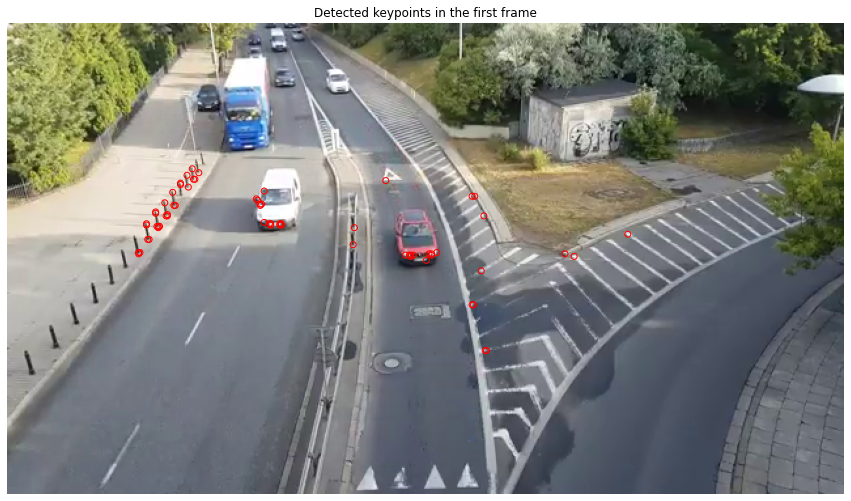

In [4]:
if __name__ == "__main__":
  # read video into numpy array
  car_video = read_video_into_numpy(path+"cars.mp4")

  # select the first frame as the input image for corner detection
  # and convert the image to float32 and grayscale
  gray_img = np.float32(cv.cvtColor(car_video[0], cv.COLOR_BGR2GRAY))

  # detect corners using Harris corner detection
  corners = cv.cornerHarris(gray_img, 2, 3, 0.04)

  y, x, channel = car_video[0].shape

  threshold = 100

  # Get the indices of detected corners with response value greater than 20% of the maximum response value
  detected_corners = np.argwhere(corners>0.2 * corners.max())

  # Get the indices of corners that are too close to the image boundary in x-direction
  index_x = np.argwhere((detected_corners[:,0] < threshold) | (detected_corners[:, 0] > y-threshold))
  # Get the indices of corners that are too close to the image boundary in y-direction
  index_y = np.argwhere((detected_corners[:,1] < threshold) | (detected_corners[:, 1] > x-threshold))
  # Concatenate the indices of corners too close to the boundary in x-direction and y-direction
  index = np.unique(np.concatenate((index_x, index_y), axis=0))
  # Delete the indices of corners too close to the image boundary to obtain the final keypoints
  keypoints = np.delete(detected_corners, index, axis = 0)

  # Plot flow vectors
  plt.figure(figsize=(15,12))
  plt.imshow(car_video[0])
  # plt.imshow(corners, cmap='gray')
  plt.scatter(keypoints[:,1], keypoints[:,0],
        facecolors='none', edgecolors=(255/255, 0/255, 0/255))
  plt.axis('off')
  plt.title('Detected keypoints in the first frame')

In [5]:
def lucas_kanade_algorithm(imgA, imgB, keypoints, curr_flow, window_size=9, num_iters=6):
  flow_vectors = []
  w = window_size // 2

  # Compute the spatial gradient of imgA and imgB in x and y directions
  Ix = np.zeros_like(imgA)
  Iy = np.zeros_like(imgB)

  for channel in range(3):
    Iy[:, :, channel], Ix[:, :, channel] = np.gradient(imgA[:, :, channel])

  # For each keypoint in imgA, estimate the flow vector
  for i in range(len(keypoints)):
    v = np.zeros(2)
    y1 = int(round(keypoints[i][0])) # y-coordinate of the keypoint in imgA
    x1 = int(round(keypoints[i][1])) # x-coordinate of the keypoint in imgA

    # Compute the gradient at the keypoint location
    wx = Ix[y1-w : y1+w+1, x1-w : x1+w+1, :]
    wy = Iy[y1-w : y1+w+1, x1-w : x1+w+1, :]
    g0 = np.sum(wx**2)
    g1 = np.sum(wx * wy)
    g2 = np.sum(wy**2)
    G = np.array([[g0, g1],
            [g1, g2]])
    G_inv = np.linalg.inv(G)

    # Refine the flow vector using Lucas-Kanade algorithm
    for k in range(num_iters):
      vx, vy = v

      x2 = int(round(keypoints[i][1] + curr_flow[i][1] + vx)) # x-coordinate of the corresponding point in imgB
      y2 = int(round(keypoints[i][0] + curr_flow[i][0] + vy)) # y-coordinate of the corresponding point in imgB

      # Compute the error between the patch around the keypoint in imgA and the patch around the corresponding point in imgB
      Ik =  imgA[y1-w : y1+w+1, x1-w : x1+w+1, :] - imgB[y2-w : y2+w+1, x2-w : x2+w+1, :]
      bk0 = np.sum(Ik * wx)
      bk1 = np.sum(Ik * wy)
      bk = np.array([bk0,bk1])

      # Update the flow vector using the inverse of the Hessian matrix and the error
      v += G_inv @ bk

    flow_vectors.append([v[1], v[0]])

  # Return the optical flow vectors for each keypoint
  return np.array(flow_vectors)

In [6]:
def lucas_kanade_pyramid(imgA, imgB, keypoints, n_levels = 4, window_size = 9, num_iters=6, scale=2):
  # Generate Gaussian pyramid for both images
  gaussian_A = tuple(pyramid_gaussian(imgA, max_layer=n_levels, downscale=scale, multichannel=True))
  gaussian_B = tuple(pyramid_gaussian(imgB, max_layer=n_levels, downscale=scale, multichannel=True))

  # Initialize the current flow vector
  curr_flow = np.zeros(keypoints.shape)

  # Loop through the pyramid levels in reverse order
  for i in reversed(range(n_levels)):
    # Get the images and keypoints at the current level
    imgA_level = gaussian_A[i]
    imgB_level = gaussian_B[i]
    keypoints_level = keypoints / (scale ** i)
      
    # Compute the flow vectors for this level using the Lucas-Kanade algorithm
    flow_v = lucas_kanade_algorithm(imgA_level, imgB_level, keypoints_level, curr_flow, window_size, num_iters)

    # If we are not at the base level, scale the flow vectors and add to the current flow vector
    if i > 0:
      curr_flow = scale * (curr_flow + flow_v)

  # Return the final flow vectors to the current flow vector
  return curr_flow + flow_v

In [7]:
def compute_lucas_kanade_optical_flow(video, threshold, n_levels = 4, window_size = 9, num_iters=6, keypoints_circle_size = 3):
  # select the first frame as the input image for corner detection
  # and convert the image to float32 and grayscale
  gray_img = np.float32(cv.cvtColor(video[0], cv.COLOR_BGR2GRAY))

  # detect corners using Harris corner detection
  corners = cv.cornerHarris(gray_img, 2, 3, 0.04)

  y, x, channel = video[0].shape

  # Get the indices of detected corners with response value greater than 20% of the maximum response value
  detected_corners = np.argwhere(corners>0.2 * corners.max())

  # Get the indices of corners that are too close to the image boundary in x-direction
  index_x = np.argwhere((detected_corners[:,0] < threshold) | (detected_corners[:, 0] > y-threshold))
  # Get the indices of corners that are too close to the image boundary in y-direction
  index_y = np.argwhere((detected_corners[:,1] < threshold) | (detected_corners[:, 1] > x-threshold))
  # Concatenate the indices of corners too close to the boundary in x-direction and y-direction
  index = np.unique(np.concatenate((index_x, index_y), axis=0))
  # Delete the indices of corners too close to the image boundary to obtain the final keypoints
  keypoints = np.delete(detected_corners, index, axis = 0)

  # Plot flow vectors
  plt.figure(figsize=(15,12))
  plt.imshow(video[0])
  # plt.imshow(corners, cmap='gray')
  plt.scatter(keypoints[:,1], keypoints[:,0],
        facecolors='none', edgecolors=(255/255, 0/255, 0/255))
  plt.axis('off')
  plt.title('Detected keypoints in the first frame')

  im_list = []

  # iterate over each frame in the video
  for i in range(len(car_video)-1):
    imgA = video[i]
    imgB = video[i+1]

    # use Lucas-Kanade pyramid algorithm to compute optical flow between two frames
    flow = lucas_kanade_pyramid(imgA, imgB, keypoints, n_levels, window_size, num_iters)
    next_keypoints = keypoints + flow

    # draw circles on the current frame around the tracked keypoints
    for current_keypoints in next_keypoints:
      cv.circle(imgA, (int(current_keypoints[1]), int(current_keypoints[0])), keypoints_circle_size, (255,0,0), 1)

    im_list.append(imgA)

    # update the keypoints for the next iteration
    keypoints = next_keypoints

  return im_list

Can't receive frame (stream end?). Exiting ...


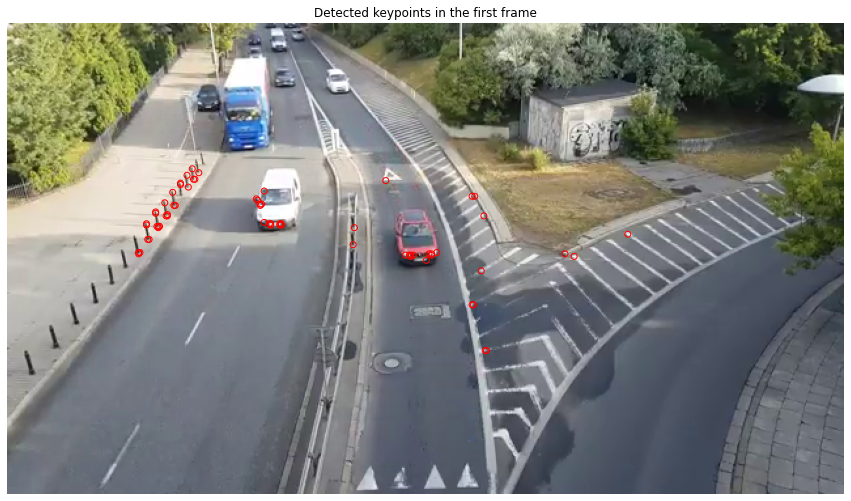

In [8]:
if __name__ == "__main__":
  # read video into numpy array
  car_video = read_video_into_numpy(path+"cars.mp4")

  # Set the threshold for detected corners
  threshold = 100
  
  # Set the number of pyramid levels, size of the window and number of iterations for Lucas-Kanade algorithm
  n_levels = 3
  window_size = 9
  num_iters = 6

  # Set the size of the circle to draw around keypoints
  keypoints_circle_size = 3

  optical_flow = compute_lucas_kanade_optical_flow(car_video, threshold, n_levels, window_size, num_iters, keypoints_circle_size)

  # save the tracked frames as an animated gif
  imageio.mimsave(path+'tracking.gif', optical_flow, fps=10)

## 1.2 Horn-Schunck (5 points)
Implement the Horn-Schunck algorithm. Display the flow fields for the ‘Army,’
‘Backyard,’ and ‘Mequon’ test cases from the Middlebury dataset, [located here](https://vision.middlebury.edu/flow/data/comp/zip/eval-color-twoframes.zip).
Consider ‘frame10.png’ as the first frame, and ‘frame11.png’ as the second frame for all
cases.

Use this code to display each predicted flow field as a colored image:
  
    hsv = np.zeros(im.shape, dtype=np.uint8)
    hsv[..., 1] = 255
    mag, ang = cv.cartToPolar(flow_x, flow_y)
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    out = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)

In [9]:
def bilinear_interpolation(img, x, y):
    shapeX_edge, shapeY_edge = img.shape[0], img.shape[1]
    newX1 = max(0, int(np.floor(x)))
    newY1 = max(0, int(np.floor(y)))
    newX2 = min(shapeX_edge-1, int(np.ceil(x)))
    newY2 = min(shapeY_edge-1, int(np.ceil(y)))

    if newX2 == newX1 and newY2 == newY1:
        return img[newX1, newY1]

    if x == newX1 and (y != newY1 or y != newY2):
        color1, color2 = img[newX1, newY1], img[newX1, newY2]
        weight1, weight2 = 1*(newY2-y), 1*(y-newY1)
        return color1*weight1 + color2*weight2
    
    if y == newY1 and (x != newX1 or x != newX2):
        color1, color4 = img[newX1, newY1], img[newX2, newY2]
        weight1, weight4 = (newX2-x)*1, (x-newX1)*1
        return color1*weight1 + color4*weight4

    color1, color2, color3, color4 = img[newX1, newY1], img[newX1, newY2], img[newX2, newY1], img[newX2, newY2]
    weight1, weight2, weight3, weight4 = (newX2-x)*(newY2-y), (newX2-x)*(y-newY1), (x-newX1)*(newY2-y), (x-newX1)*(y-newY1)
    return color1*weight1 + color2*weight2 + color3*weight3 + color4*weight4

In [10]:
def horn_schunck_algorithm(A_x, A_y, A_t, lam, flow, kernel, num_iter=100):
  count = 0

  # Iterate until convergence or maximum number of iterations
  while count < num_iter:
      F_vector = [cv.filter2D(flow[0], -1, kernel), cv.filter2D(flow[1], -1, kernel)]

      # Compute B and G
      B = A_x * F_vector[0] + A_y * F_vector[1] + A_t
      G = lam + A_x ** 2 + A_y ** 2

      # Update flow vector
      flow[0] = F_vector[0] - (B * A_x) / G
      flow[1] = F_vector[1] - (B * A_y) / G

      count += 1

      # Check for convergence
      if np.allclose(flow, F_vector):
        break
  return F_vector

In [11]:
def compute_horn_schunck_optical_flow(imgA, imgB, lam, n_levels, num_iter):
    # Generate Gaussian pyramid for both images
    gaussian_A = tuple(pyramid_gaussian(imgA, max_layer=n_levels, downscale=2, multichannel=False))
    gaussian_B = tuple(pyramid_gaussian(imgB, max_layer=n_levels, downscale=2, multichannel=False))

    # Initialize flow to zero
    flow = np.array([np.zeros(gaussian_A[-1].shape), np.zeros(gaussian_A[-1].shape)])

    # Using Laplace operator to find the second derivative
    kernel = 1/4 * np.array([[0, 1, 0], 
                  [1, 0, 1], 
                  [0, 1, 0]])

    # For each pyramid level
    for l in range(n_levels, -1, -1):
        # Compute spatial derivatives of A^l
        A_x = cv.Sobel(gaussian_A[l], cv.CV_32F, 1, 0, ksize=3)
        A_y = cv.Sobel(gaussian_A[l], cv.CV_32F, 0, 1, ksize=3)
        A_y = cv.convertScaleAbs(A_y)
        
        # Compute temporal gradient
        A_t = np.zeros(gaussian_A[l].shape)
        for x in range(gaussian_A[l].shape[0]):
            for y in range(gaussian_A[l].shape[1]):
                x2 = int(round(x + flow[0][x, y]))
                y2 = int(round(y + flow[1][x, y]))
                bilinear_B = bilinear_interpolation(gaussian_B[l], x2, y2)
                A_t[x, y] = bilinear_B - gaussian_A[l][x,y]

        # Solving for the velocity vectors only for all Points; Iteration to reduce error
        flow = horn_schunck_algorithm(A_x, A_y, A_t, lam, flow, kernel, num_iter=100)

        # Upsample 2x for the next level and multiply by 2
        if l > 0:            
            size = (gaussian_A[l-1].shape[1], gaussian_A[l-1].shape[0])
            flow[0] = 2 * cv.pyrUp(flow[0], dstsize=size)
            flow[1] = 2 * cv.pyrUp(flow[1], dstsize=size)

    return flow

In [12]:
def display_field(im, flow_x, flow_y):
  hsv = np.zeros(im.shape, dtype=np.uint8)
  hsv[..., 1] = 128
  mag, ang = cv.cartToPolar(flow_x, flow_y)
  hsv[..., 0] = ang * 180 / np.pi / 2
  hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
  out = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)
  out = cv.convertScaleAbs(out, alpha=4)
  return out

<Figure size 432x288 with 0 Axes>

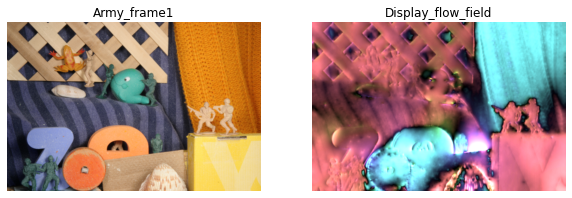

In [13]:
if __name__ == "__main__":
  # Load sample images
  Army_frame1 = Image.open(path + '/eval-data/Army/frame10.png')
  Army_frame1 = np.array(Army_frame1, dtype=np.float32)
  Army_frame1 = (Army_frame1 / 255.0)
  Army_frame1_gray = cv.cvtColor(Army_frame1, cv.COLOR_BGR2GRAY)

  Army_frame2 = Image.open(path + '/eval-data/Army/frame11.png')
  Army_frame2 = np.array(Army_frame2, dtype=np.float32)
  Army_frame2 = (Army_frame2 / 255.0)
  Army_frame2_gray = cv.cvtColor(Army_frame2, cv.COLOR_BGR2GRAY)

  lam = 1
  n_levels = 3
  num_iter=100
  
  # Load sample images
  flow = compute_horn_schunck_optical_flow(Army_frame1_gray, Army_frame2_gray, lam, n_levels, num_iter)

  # Display flow field
  Display_flow_field = display_field(Army_frame1, flow[0], flow[1])

  # Show the Army and flow field images
  plt.figure()
  fig, ax = plt.subplots(1, 2, figsize=(10, 18)) 
  output_images = [Army_frame1, Display_flow_field]
  titles = ['Army_frame1', 'Display_flow_field']
  index = 0
  for i in range(2):
    ax[i].imshow(output_images[index])
    ax[i].axis('off')
    ax[i].set_title(f"{titles[index]}")
    index += 1

<Figure size 432x288 with 0 Axes>

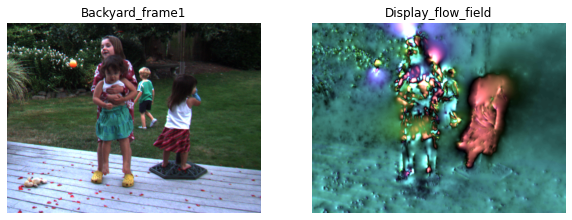

In [14]:
if __name__ == "__main__":
  # Load sample images
  Backyard_frame1 = Image.open(path + '/eval-data/Backyard/frame10.png')
  Backyard_frame1 = np.array(Backyard_frame1, dtype=np.float32)
  Backyard_frame1 = (Backyard_frame1 / 255.0)
  Backyard_frame1_gray = cv.cvtColor(Backyard_frame1, cv.COLOR_BGR2GRAY)

  Backyard_frame2 = Image.open(path + '/eval-data/Backyard/frame11.png')
  Backyard_frame2 = np.array(Backyard_frame2, dtype=np.float32)
  Backyard_frame2 = (Backyard_frame2 / 255.0)
  Backyard_frame2_gray = cv.cvtColor(Backyard_frame2, cv.COLOR_BGR2GRAY)

  lam = 1
  n_levels = 3
  num_iter=100
  
  # Load sample images
  flow = compute_horn_schunck_optical_flow(Backyard_frame1_gray, Backyard_frame2_gray, lam, n_levels, num_iter)

  # Display flow field
  Display_flow_field = display_field(Backyard_frame1, flow[0], flow[1])

  # Show the Backyard and flow field images
  plt.figure()
  fig, ax = plt.subplots(1, 2, figsize=(10, 18)) 
  output_images = [Backyard_frame1, Display_flow_field]
  titles = ['Backyard_frame1', 'Display_flow_field']
  index = 0
  for i in range(2):
    ax[i].imshow(output_images[index])
    ax[i].axis('off')
    ax[i].set_title(f"{titles[index]}")
    index += 1

<Figure size 432x288 with 0 Axes>

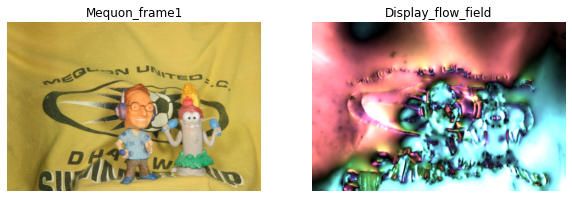

In [15]:
if __name__ == "__main__":
  # Load sample images
  Mequon_frame1 = Image.open(path + '/eval-data/Mequon/frame10.png')
  Mequon_frame1 = np.array(Mequon_frame1, dtype=np.float32)
  Mequon_frame1 = (Mequon_frame1 / 255.0)
  Mequon_frame1_gray = cv.cvtColor(Mequon_frame1, cv.COLOR_BGR2GRAY)

  Mequon_frame2 = Image.open(path + '/eval-data/Mequon/frame11.png')
  Mequon_frame2 = np.array(Mequon_frame2, dtype=np.float32)
  Mequon_frame2 = (Mequon_frame2 / 255.0)
  Mequon_frame2_gray = cv.cvtColor(Mequon_frame2, cv.COLOR_BGR2GRAY)

  lam = 1
  n_levels = 3
  num_iter=100
  
  # Load sample images
  flow = compute_horn_schunck_optical_flow(Mequon_frame1_gray, Mequon_frame2_gray, lam, n_levels, num_iter)

  # Display flow field
  Display_flow_field = display_field(Mequon_frame1, flow[0], flow[1])

  # Show the Mequon and flow field images
  plt.figure()
  fig, ax = plt.subplots(1, 2, figsize=(10, 18)) 
  output_images = [Mequon_frame1, Display_flow_field]
  titles = ['Mequon_frame1', 'Display_flow_field']
  index = 0
  for i in range(2):
    ax[i].imshow(output_images[index])
    ax[i].axis('off')
    ax[i].set_title(f"{titles[index]}")
    index += 1

## 1.3 **(ELEC/COMP 546 Only)** Improving Horn-Schunck with superpixels (5 points)
Recall superpixels discussed in lecture and described further [in this paper](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf). How might you use superpixels to improve the performance of Horn-Schunck? Can you incorporate your idea into the smoothness + brightness constancy objection function? Define any notation you wish to use in the equation. You don’t have to implement your idea in code for this question.

# 2.0 Image Compression with PCA
In this problem, you will use PCA to compress images, by encoding small patches in low-dimensional subspaces. Download these two images:

[Test Image 1](https://drive.google.com/file/d/1n2BK1Fn2s0hZ8ZO9127JoRAJWabZwalA/view)

[Test Image 2](https://drive.google.com/file/d/1XiHesOsu23b26BGMz2cdIV6bhELTESHS/view)

Do the following steps for each image separately.

## 2.1 Use PCA to model patches (5 points)
Randomly sample at least 1,000 16 x 16 patches from the image. Flatten those patches into vectors (should be of size 16 x 16 x 3). Run PCA on these patches to obtain a set of principal components. Please write your own code to perform PCA. You may use **numpy.linalg.eigh**, or **numpy.linalg.svd** to obtain eigenvectors.

Display the first 36 principal components as 16 x 16 images, arranged in a 6 x 6 grid (Note: remember to sort your eigenvalues and eigenvectors by decreasing eigenvalue magnitude!). Also report the % of variance captured by all principal components (not just the first 36) in a plot, with the x-axis being the component number, and y-axis being the % of variance explained by that component.



In [16]:
def PCA (img, patch_size, num_patches):
  # Sample random patches
  num_patch_X = int(img.shape[0] / patch_size)
  num_patch_Y = int(img.shape[1] / patch_size)
  num_patches = (num_patch_X + 1) * (num_patch_Y + 1)

  patches = []
  for i in range(num_patch_X+1):
    for j in range(num_patch_Y):
      if not i == num_patch_X:
        patch = img[i*patch_size:i*patch_size+16, j*patch_size:j*patch_size+16, :]
        patches.append(patch)
        if j == num_patch_Y-1 :
          patch = img[i*patch_size:i*patch_size+16, img.shape[1]-16:img.shape[1], :]
          patches.append(patch)
      else:
        patch = img[img.shape[0]-16:img.shape[0], j*patch_size:j*patch_size+16, :]
        patches.append(patch)
        if j == num_patch_Y-1 :
          patch = img[img.shape[0]-16:img.shape[0], img.shape[1]-16:img.shape[1], :]
          patches.append(patch)

  # Flatten the patches into vectors
  patches_flat = np.array(patches).reshape(num_patches, -1)

  # Compute the mean of the flattened patches
  X_mean = np.mean(patches_flat, axis=0)

  # Subtract the mean from the patches
  patches_centered = patches_flat - X_mean

  V = np.dot(patches_centered.T, patches_centered)

  # Compute the eigenvectors and eigenvalues of the covariance matrix
  eigenvalues, eigenvectors = np.linalg.eigh(V)

  # Sort the eigenvectors by decreasing eigenvalue magnitude
  sorted_idx = np.argsort(eigenvalues)[::-1]
  sorted_eigenvalues = eigenvalues[sorted_idx]
  sorted_eigenvectors = eigenvectors[:, sorted_idx]

  return patches_flat, patches, X_mean, eigenvalues, eigenvectors, sorted_eigenvalues, sorted_eigenvectors

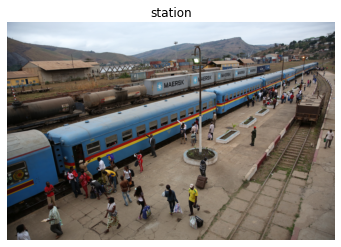

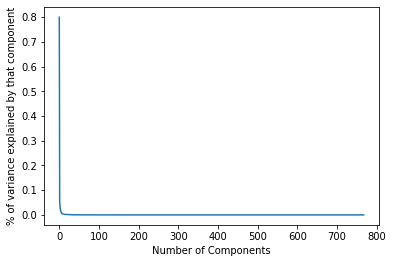

In [17]:
if __name__ == '__main__':
  # Load the image
  img = Image.open(path + 'station.png')

  # Convert the image to a numpy array
  img = np.array(img)

  # Plot the station image
  plt.imshow(img)
  plt.title("station")
  plt.axis('off')
  plt.show()

  # Set patch size and number of patches
  patch_size = 16
  num_patches = 1000

  patches_flat, patches, X_mean, eigenvalues, eigenvectors, sorted_eigenvalues, sorted_eigenvectors = PCA(img, patch_size, num_patches)

  # Compute the cumulative explained variance ratio
  explained_variances = sorted_eigenvalues / np.sum(sorted_eigenvalues)

  # Plot the % of variance explained by that component
  plt.plot(explained_variances)
  plt.xlabel('Number of Components')
  plt.ylabel('% of variance explained by that component')
  plt.show()

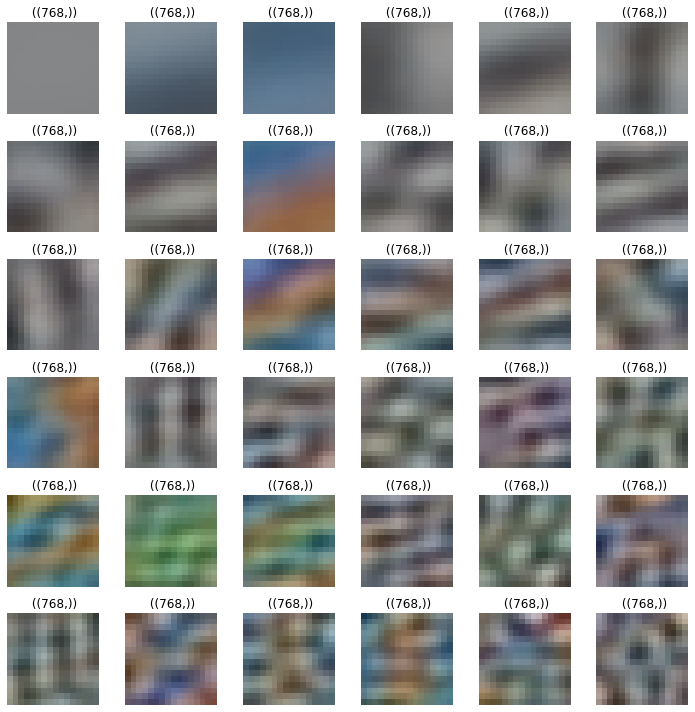

In [18]:
if __name__ == '__main__':
  # Load the image
  img = Image.open(path + 'station.png')

  # Convert the image to a numpy array
  img = np.array(img)

  # Set patch size and number of patches
  patch_size = 16
  num_patches = 1000

  patches_flat, patches, X_mean, eigenvalues, eigenvectors, sorted_eigenvalues, sorted_eigenvectors = PCA(img, patch_size, num_patches)

  # Normalize the eigenvectors
  sorted_eigenvectors = cv.normalize(sorted_eigenvectors, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

  # Display the first 36 principal components
  fig, ax = plt.subplots(6, 6, figsize=(10, 10))
  index = 0
  for i in range(6):
    for j in range(6):
      pc = sorted_eigenvectors[:, i*6 + j].reshape(patch_size, patch_size, 3)
      ax[i][j].imshow(pc)
      ax[i][j].set_title(f" ({sorted_eigenvectors[index].shape})")
      ax[i][j].axis('off')

  plt.tight_layout()
  plt.show()

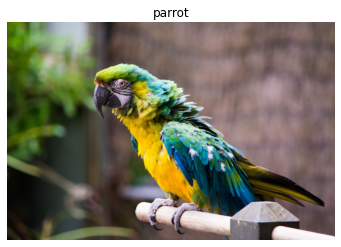

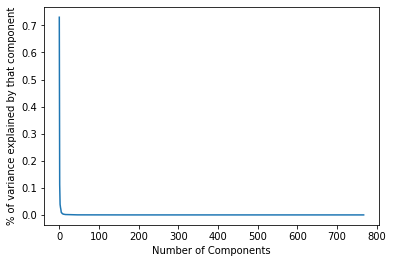

In [19]:
if __name__ == '__main__':
  # Load the image
  img = Image.open(path + 'parrot.png')

  # Convert the image to a numpy array
  img = np.array(img)

  # Plot the station image
  plt.imshow(img)
  plt.title("parrot")
  plt.axis('off')
  plt.show()

  # Set patch size and number of patches
  patch_size = 16
  num_patches = 1000

  patches_flat, patches, X_mean, eigenvalues, eigenvectors, sorted_eigenvalues, sorted_eigenvectors = PCA(img, patch_size, num_patches)

  # Compute the cumulative explained variance ratio
  explained_variances = sorted_eigenvalues / np.sum(sorted_eigenvalues)

  # Plot the % of variance explained by that component
  plt.plot(explained_variances)
  plt.xlabel('Number of Components')
  plt.ylabel('% of variance explained by that component')
  plt.show()

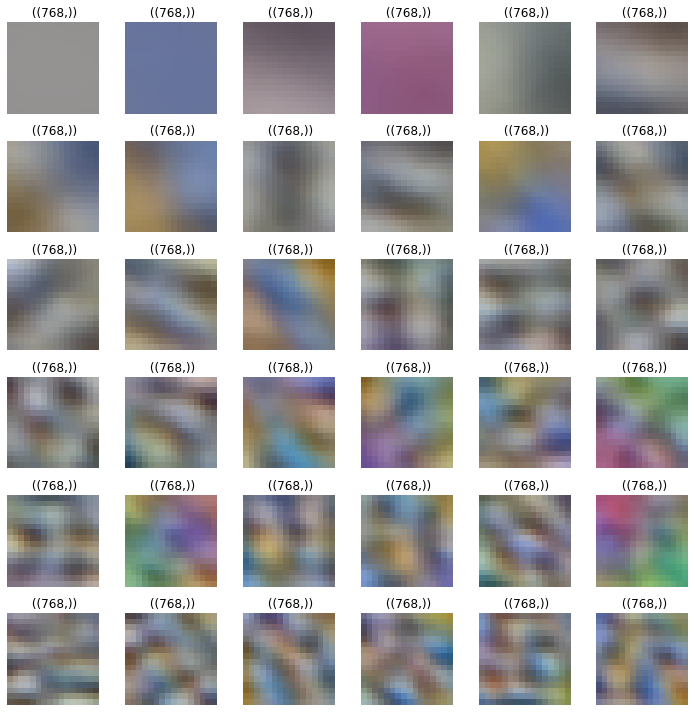

In [20]:
if __name__ == '__main__':
  # Load the image
  img = Image.open(path + 'parrot.png')

  # Convert the image to a numpy array
  img = np.array(img)

  # Set patch size and number of patches
  patch_size = 16
  num_patches = 1000

  patches_flat, patches, X_mean, eigenvalues, eigenvectors, sorted_eigenvalues, sorted_eigenvectors = PCA(img, patch_size, num_patches)

  # Normalize the eigenvectors
  sorted_eigenvectors = cv.normalize(sorted_eigenvectors, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

  # Display the first 36 principal components
  fig, ax = plt.subplots(6, 6, figsize=(10, 10))
  index = 0
  for i in range(6):
    for j in range(6):
      pc = sorted_eigenvectors[:, i*6 + j].reshape(patch_size, patch_size, 3)
      ax[i][j].imshow(pc)
      ax[i][j].set_title(f" ({sorted_eigenvectors[index].shape})")
      ax[i][j].axis('off')

  plt.tight_layout()
  plt.show()

## 2.2 Compress the image (5 points)
Show image reconstruction results using 1, 3, 10, 50, and 100 principal components. To do this, divide the image into non-overlapping 16 x 16 patches, and reconstruct each patch independently using the principal components. Answer the following questions:

1. Was one image easier to compress than another? If so, why do you think that is the case?
2. What are some similarities and differences between the principal components for the two images, and your interpretation for the reason behind them?


In [21]:
def reconstruct_image(image, patches_flat, X_mean, eigenvectors):
  """
  Reconstructs the original image from compressed patches.

  Args:
  - image (np.ndarray): the original image
  - patches_flat (np.ndarray): the flattened compressed patches
  - X_mean (np.ndarray): the mean patch
  - eigenvectors (np.ndarray): the eigenvectors

  Returns:
  - compressed_image (np.ndarray): the reconstructed image
  """
  # Reconstruct patches
  reconstructed_patches = np.dot(patches_flat, eigenvectors) @ eigenvectors.T + X_mean

  # Reshape patches to (16, 16, 3)
  reshaped_patches = [patch.reshape(16, 16, 3) for patch in reconstructed_patches]

  # Calculate the number of patches in each row and column
  num_patch_rows = image.shape[0] // 16 + 1
  num_patch_cols = image.shape[1] // 16 + 1

  # Calculate the size of the last patch in each row and column
  last_patch_rows = image.shape[0] - 16*(num_patch_rows-1)
  last_patch_cols = image.shape[1] - 16*(num_patch_cols-1)

  # Create a new image array to store the compressed patches
  compressed_image = np.zeros([num_patch_rows, num_patch_cols, 3])

  # Loop over each row of patches
  index_count = 0
  for i in range(num_patch_rows):
    # Handle the last row of patches separately
    if i == num_patch_rows-1:
      row = reshaped_patches[index_count][16-last_patch_rows:16, :, :]
    else:
      row = reshaped_patches[index_count]
    index_count += 1

    # Loop over each patch in the current row
    for j in range(1, num_patch_cols):
      # Handle the last patch in the current row separately
      if i != num_patch_rows-1:
        if j != num_patch_cols-1:
          new_row = reshaped_patches[index_count]
        else:
          new_row = reshaped_patches[index_count][:, 16-last_patch_cols:16, :]
      else:
        if j != num_patch_cols-1:
          new_row = reshaped_patches[index_count][16-last_patch_rows:16, :, :]
        else:
          new_row = reshaped_patches[index_count][16-last_patch_rows:16, 16-last_patch_cols:16, :]
      row = np.concatenate((row, new_row), axis=1)
      index_count += 1

    # Concatenate the current row of patches to the new image array
    if i == 0:
      column = row
      continue
    column = np.concatenate((column, row), axis=0)

  # Store the compressed patches in the new image array
  compressed_image = column
  return compressed_image

<Figure size 432x288 with 0 Axes>

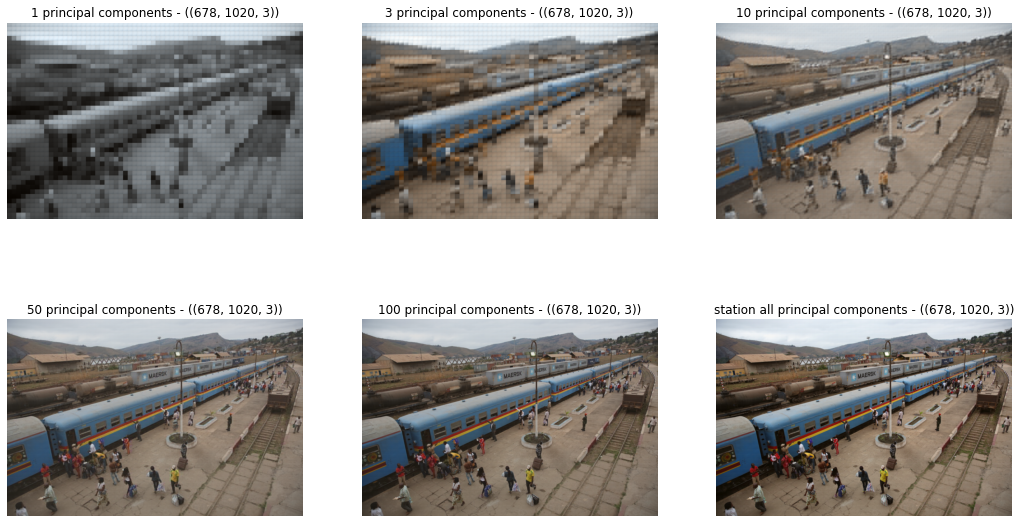

In [22]:
if __name__ == '__main__':
  # Load the image
  img = Image.open(path + 'station.png')

  # Convert the image to a numpy array and change its datatype to float32
  img = np.array(img, dtype=np.float32)

  # Set patch size and number of patches
  patch_size = 16
  num_patches = 1000

  # Apply PCA to the image to get flattened patches, mean image, eigenvalues, and eigenvectors
  patches_flat, patches, X_mean, eigenvalues, eigenvectors, sorted_eigenvalues, sorted_eigenvectors = PCA(img, patch_size, num_patches)

  # Select different numbers of principal components and reconstruct the image using those components
  PC_1 = sorted_eigenvectors[:,:1]
  PC_3 = sorted_eigenvectors[:,:3]
  PC_10 = sorted_eigenvectors[:,:10]
  PC_50 = sorted_eigenvectors[:,:50]
  PC_100 = sorted_eigenvectors[:,:100]

  PC_list = [] 
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, PC_1))
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, PC_3))
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, PC_10))
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, PC_50))
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, PC_100))
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, sorted_eigenvectors))

  # Normalize each image in the PC_list
  for i in range(len(PC_list)):
    PC_list[i] = PC_list[i].astype(np.float32)
    PC_list[i] = (PC_list[i] - np.min(PC_list[i])) / (np.max(PC_list[i]) - np.min(PC_list[i]))

  # Plot the PC_list images
  plt.figure()
  fig, ax = plt.subplots(2, 3, figsize=(18, 10))
  titles = ["1 principal components", "3 principal components", "10 principal components", 
        "50 principal components", "100 principal components", "station all principal components"]
  index = 0
  for i in range(2):
    for j in range(3):
      ax[i][j].imshow(PC_list[index])
      ax[i][j].axis('off')
      ax[i][j].set_title(f"{titles[index]} - ({PC_list[index].shape})")
      index += 1
  plt.show()

<Figure size 432x288 with 0 Axes>

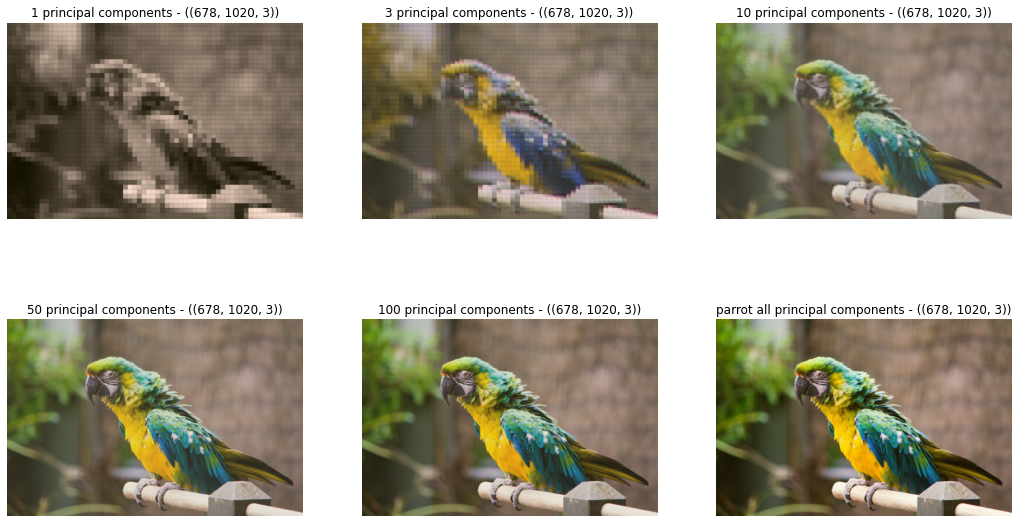

In [23]:
if __name__ == '__main__':
  # Load the image
  img = Image.open(path + 'parrot.png')

  # Convert the image to a numpy array and change its datatype to float32
  img = np.array(img, dtype=np.float32)

  # Set patch size and number of patches
  patch_size = 16
  num_patches = 1000

  # Apply PCA to the image to get flattened patches, mean image, eigenvalues, and eigenvectors
  patches_flat, patches, X_mean, eigenvalues, eigenvectors, sorted_eigenvalues, sorted_eigenvectors = PCA(img, patch_size, num_patches)

  # Select different numbers of principal components and reconstruct the image using those components
  PC_1 = sorted_eigenvectors[:,:1]
  PC_3 = sorted_eigenvectors[:,:3]
  PC_10 = sorted_eigenvectors[:,:10]
  PC_50 = sorted_eigenvectors[:,:50]
  PC_100 = sorted_eigenvectors[:,:100]

  PC_list = [] 
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, PC_1))
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, PC_3))
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, PC_10))
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, PC_50))
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, PC_100))
  PC_list.append(reconstruct_image(img, patches_flat, X_mean, sorted_eigenvectors))

  # Normalize each image in the PC_list
  for i in range(len(PC_list)):
    PC_list[i] = PC_list[i].astype(np.float32)
    PC_list[i] = (PC_list[i] - np.min(PC_list[i])) / (np.max(PC_list[i]) - np.min(PC_list[i]))

  # Plot the PC_list images
  plt.figure()
  fig, ax = plt.subplots(2, 3, figsize=(18, 10))
  titles = ["1 principal components", "3 principal components", "10 principal components", 
        "50 principal components", "100 principal components", "parrot all principal components"]
  index = 0
  for i in range(2):
    for j in range(3):
      ax[i][j].imshow(PC_list[index])
      ax[i][j].axis('off')
      ax[i][j].set_title(f"{titles[index]} - ({PC_list[index].shape})")
      index += 1
  plt.show()